In [27]:
# Comment to Linda: You can delete this cell when you run the notebook.
# It's just to make sure for me that my python shell looks inside my main project folder
# instead of the subfolder in which I save this notebook.
import os
from pathlib import Path
import sys

if "__project_dir__" not in globals():
    __project_dir__ = Path.cwd().parents[1].resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [58]:
# Necessary package imports
from itertools import combinations
import json
import math
import numpy as np
import pandas as pd
from pandas import DataFrame
import re
import seaborn as sns
import tidytcells as tt
from tqdm import tqdm

In [29]:
# Load data
df = pd.read_csv("/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/gdb/beta_raw_human.csv")

# Clean the TRBV column to the level of the gene
df["TRBV"] = df["TRBV"].map(lambda x: tt.tcr.standardize(gene=x, precision="gene"))

In [30]:
# Only keep epitope groups with 100+ TCRs
df = df.groupby("Epitope").filter(lambda group: len(group) > 100)

In [31]:
# Keep a dictionary of where each epitope group is in the table
ep_groups = df.groupby("Epitope").groups

In [32]:
# Load TRBV background frequency data
with open("/home/yutanagano/Projects/tcr_embedder/notebooks/data_processing/trbv_frequencies.json", "r") as f:
    bv_bg_freqs = json.load(f)

In [33]:
# Frequency data is in counts, so normalise everything
bv_bg_freqs = {bv: bv_bg_freqs[bv] / sum(bv_bg_freqs.values()) for bv in bv_bg_freqs}

In [34]:
# Some functions to calculate functional distance
def bv_functional_distance(v1: str, v2: str) -> float:
    if v1 == v2:
        return 0.0

    functional_distances_by_epitope = []

    for epitope in df["Epitope"].unique():
        functional_distances_by_epitope.append(bv_functional_distance_by_epitope(v1, v2, epitope))

    return sum(functional_distances_by_epitope) / len(functional_distances_by_epitope)

def bv_functional_distance_by_epitope(v1: str, v2: str, epitope: str) -> float:
    df_subset = df.loc[ep_groups[epitope]]

    total_count = len(df_subset)
    v1_count = len(df_subset[df_subset["TRBV"] == v1])
    v2_count = len(df_subset[df_subset["TRBV"] == v2])

    # Expectations under baysean correction (beta posterior from uniform prior)
    v1_epitope_freq = (v1_count + 0.5) / (total_count + 1)
    v2_epitope_freq = (v2_count + 0.5) / (total_count + 1)

    v1_bg_freq = bv_bg_freqs[v1]
    v2_bg_freq = bv_bg_freqs[v2]

    signed_distance = (math.log(v1_epitope_freq) - math.log(v1_bg_freq)) - (math.log(v2_epitope_freq) - math.log(v2_bg_freq))

    return abs(signed_distance)

In [35]:
# Calculate functional distance for each pair of TRBVs
distances = dict()

for c in tqdm(combinations(bv_bg_freqs.keys(), 2), total=1128):
    distances[c] = bv_functional_distance(*c)

  0%|          | 0/1128 [00:00<?, ?it/s]

100%|██████████| 1128/1128 [03:42<00:00,  5.07it/s]


In [36]:
def order_bv(bv):
    match = re.match(r"^TRBV([0-9]+)(-([0-9]+))?$", bv)

    group_num = int(match.group(1))
    sub_num_if_any = 0 if match.group(3) is None else int(match.group(3))
    
    return (group_num, sub_num_if_any)

# Assign a number to each TRBV to make a distance matrix
bv_indices = {bv: ind for ind, bv in enumerate(sorted(bv_bg_freqs.keys(), key=order_bv))}

In [37]:
# Make a distance matrix
pdist_matrix = np.zeros((48, 48), dtype=np.float32)

for (v1, v2), distance in distances.items():
    v1i = bv_indices[v1]
    v2i = bv_indices[v2]

    pdist_matrix[v1i][v2i] = pdist_matrix[v2i][v1i] = distance

pdist_matrix = pd.DataFrame(pdist_matrix, columns=bv_indices.keys(), index=bv_indices.keys())

/home/yutanagano/Projects/tcr_embedder/.venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


/home/yutanagano/Projects/tcr_embedder/.venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


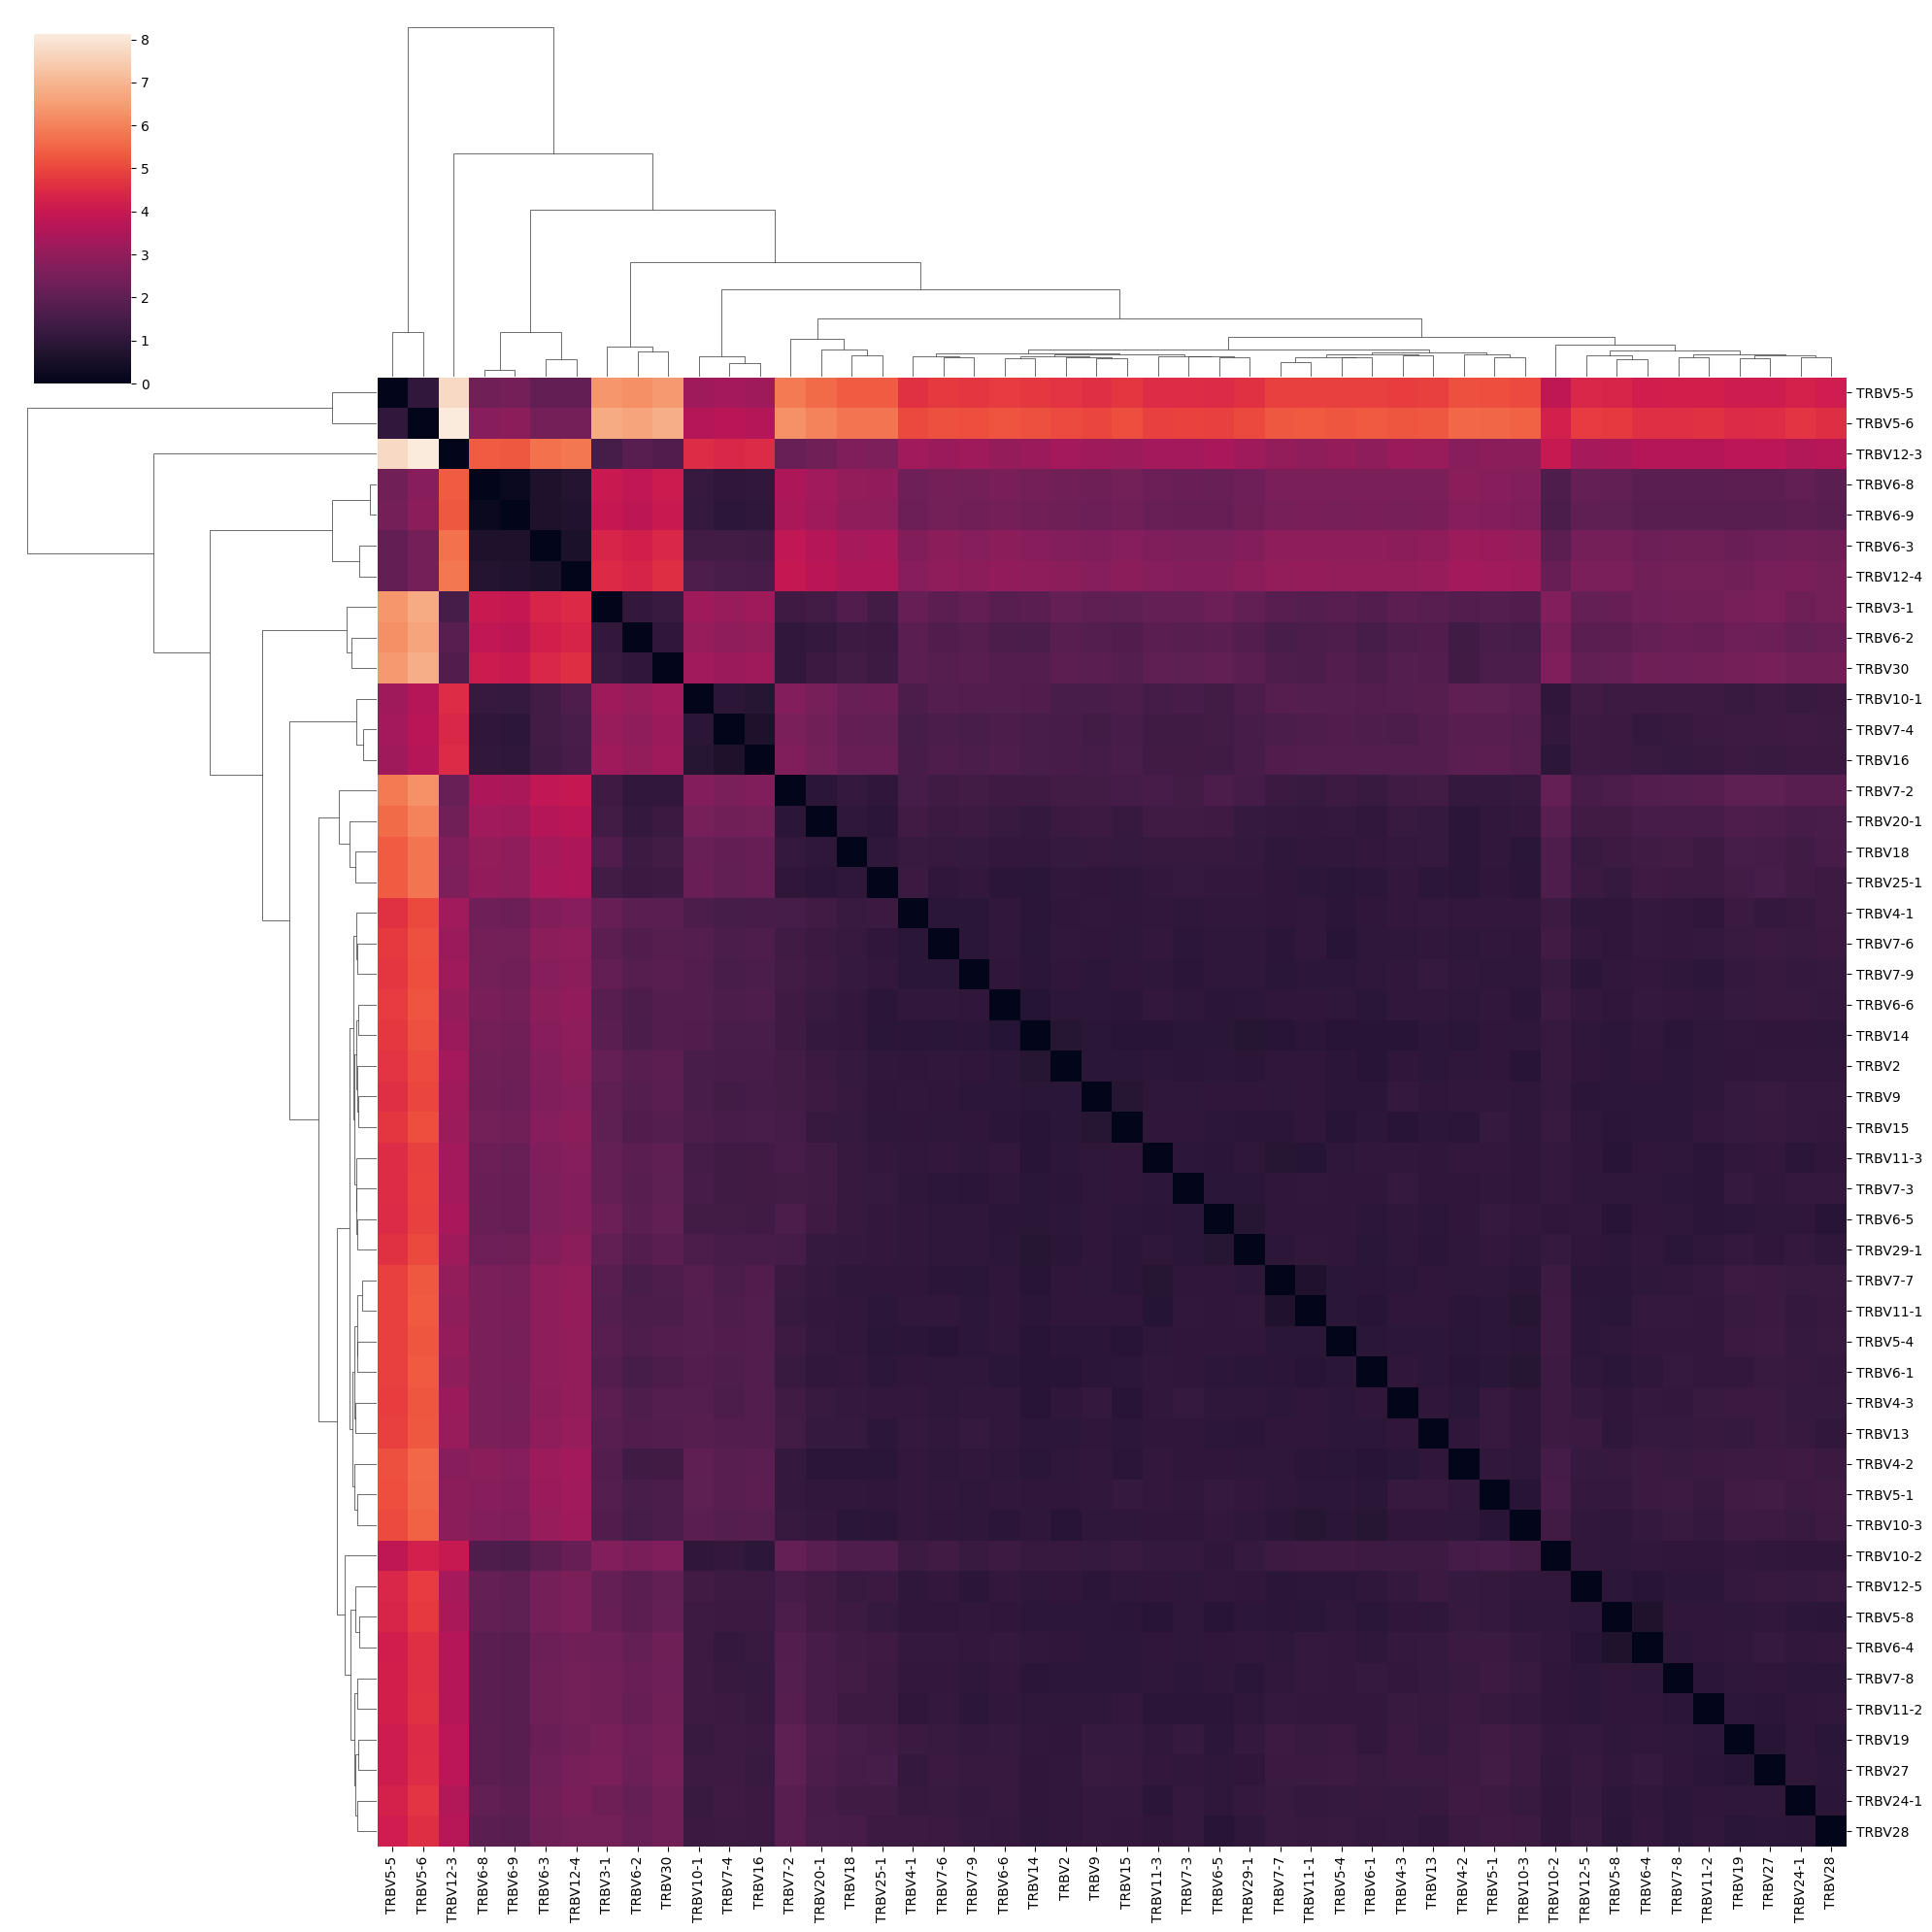

In [38]:
# Make a cluster map from the distance matrix
sns.clustermap(pdist_matrix, figsize=(20,20))

In [39]:
def bg_freq_distance(v1: str, v2: str) -> float:
    bg_freq_log_ratio = math.log(bv_bg_freqs[v1]) - math.log(bv_bg_freqs[v2])
    return abs(bg_freq_log_ratio)

In [40]:
bg_freq_distances = dict()

for c in tqdm(combinations(bv_bg_freqs.keys(), 2), total=1128):
    bg_freq_distances[c] = bg_freq_distance(*c)

100%|██████████| 1128/1128 [00:00<00:00, 509440.61it/s]


In [49]:
distance_bg_freq_coparison = DataFrame.from_records([distances, bg_freq_distances], index=["functional distance", "background frequency difference"]).T

<Axes: xlabel='functional distance', ylabel='background frequency difference'>

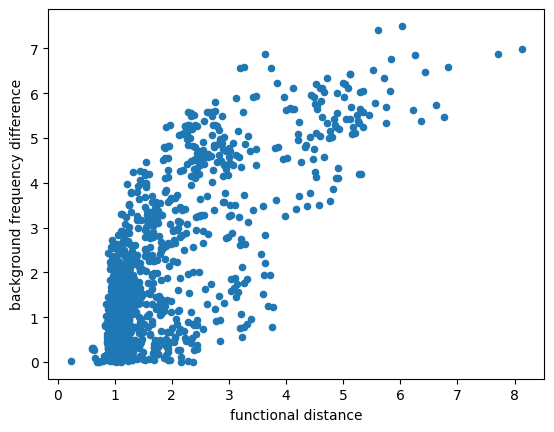

In [50]:
distance_bg_freq_coparison.plot.scatter(0,1)

In [51]:
def td_freq_distance(v1: str, v2: str) -> float:
    num_rows_v1 = (df.TRBV == v1).sum()
    num_rows_v2 = (df.TRBV == v2).sum()

    td_freq_log_ratio = math.log(num_rows_v1) - math.log(num_rows_v2)
    return abs(td_freq_log_ratio)

In [53]:
training_data_freq_distances = dict()

for c in tqdm(combinations(bv_bg_freqs.keys(), 2), total=1128):
    training_data_freq_distances[c] = td_freq_distance(*c)

100%|██████████| 1128/1128 [00:26<00:00, 41.97it/s]


In [54]:
distance_td_freq_coparison = DataFrame.from_records([distances, training_data_freq_distances], index=["functional distance", "training data frequency difference"]).T

<Axes: xlabel='functional distance', ylabel='training data frequency difference'>

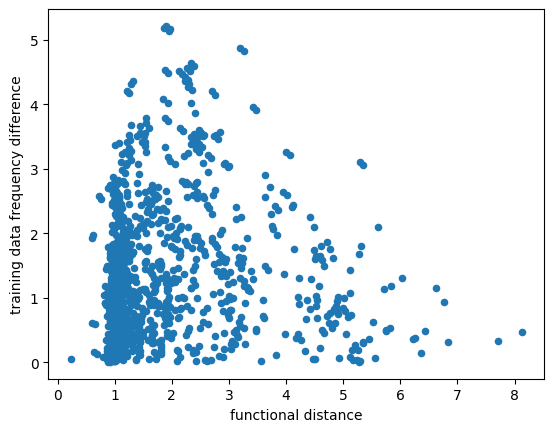

In [57]:
distance_td_freq_coparison.plot.scatter("functional distance", "training data frequency difference")